In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [ ]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [ ]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
DATASET_DIR = './'
load_dir = ''
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = './processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [ ]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

- plot

In [ ]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



In [ ]:
def choose_plot_grid(n:int,r_max=8,c_max=17):
    rs = np.sqrt(n)
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where(res==np.min(res))
    #TODO : if len(min_idx) > 1 : minimize abs(sppt-col_nums), col_nums
    return sppt[min_idx[0]], col_nums[min_idx[0]]


def plot_feat_hue(data:pd.DataFrame,hue_label_dict=None):
    num_r, num_c = choose_plot_grid(len(data))
    fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=True,sharey=True)
    for n,ax in enumerate(axes.flatten()):
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        sns.barplot(x=data.iloc[n].index, y = data.iloc[n].values,ax =ax)
        feat_name = data.index[n]
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)

    pass

## LOAD DATA

In [21]:
pvtb_name = 'pvtb_city_entire_ver0.csv'


pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_entire = pd.read_csv(pvtb_path)

pvtb_entire

geo_label_city  date_label strata_race_label strata_sex_label  \
0            Austin        2010               All             Both   
1            Austin        2010               All           Female   
2            Austin        2010               All             Male   
3            Austin        2010          Asian/PI             Both   
4            Austin        2010          Asian/PI           Female   
...             ...         ...               ...              ...   
7275     Washington        2022          Hispanic             Male   
7276     Washington        2022           Natives             Both   
7277     Washington        2022             White             Both   
7278     Washington        2022             White           Female   
7279     Washington        2022             White             Male   

      Active Transportation | Riding Bike to Work  \
0                                        1.458997   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
7275                                          NaN   
7276                                          NaN   
7277                                          NaN   
7278                                          NaN   
7279                                          NaN   

      Active Transportation | Walking to Work  \
0                                    2.506039   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
7275                                      NaN   
7276                                 8.766234   
7277                                14.201808   
7278                                      NaN   
7279                                      NaN   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                  2.191781                         25.479452   
1                                       NaN                               NaN   
2                                       NaN                               NaN   
3                                       NaN                               NaN   
4                                       NaN                               NaN   
...                                     ...                               ...   
7275                                    NaN                               NaN   
7276                                    NaN                               NaN   
7277                                    NaN                               NaN   
7278                                    NaN                               NaN   
7279                                    NaN                               NaN   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
0                                    NaN                  7.836414  ...   
1                                    NaN                       NaN  ...   
2                                    NaN                       NaN  ...   
3                                    NaN                  8.785406  ...   
4                                    NaN                       NaN  ...   
...                                  ...                       ...  ...   
7275                                 NaN                       NaN  ...   
7276                                 NaN                       NaN  ...   
7277                                 NaN                  5.574537  ...   
7278                                 NaN                       NaN  ...   
7279                                 NaN                       NaN  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', 2000)

In [ ]:
pvtb_entire

<AxesSubplot: >

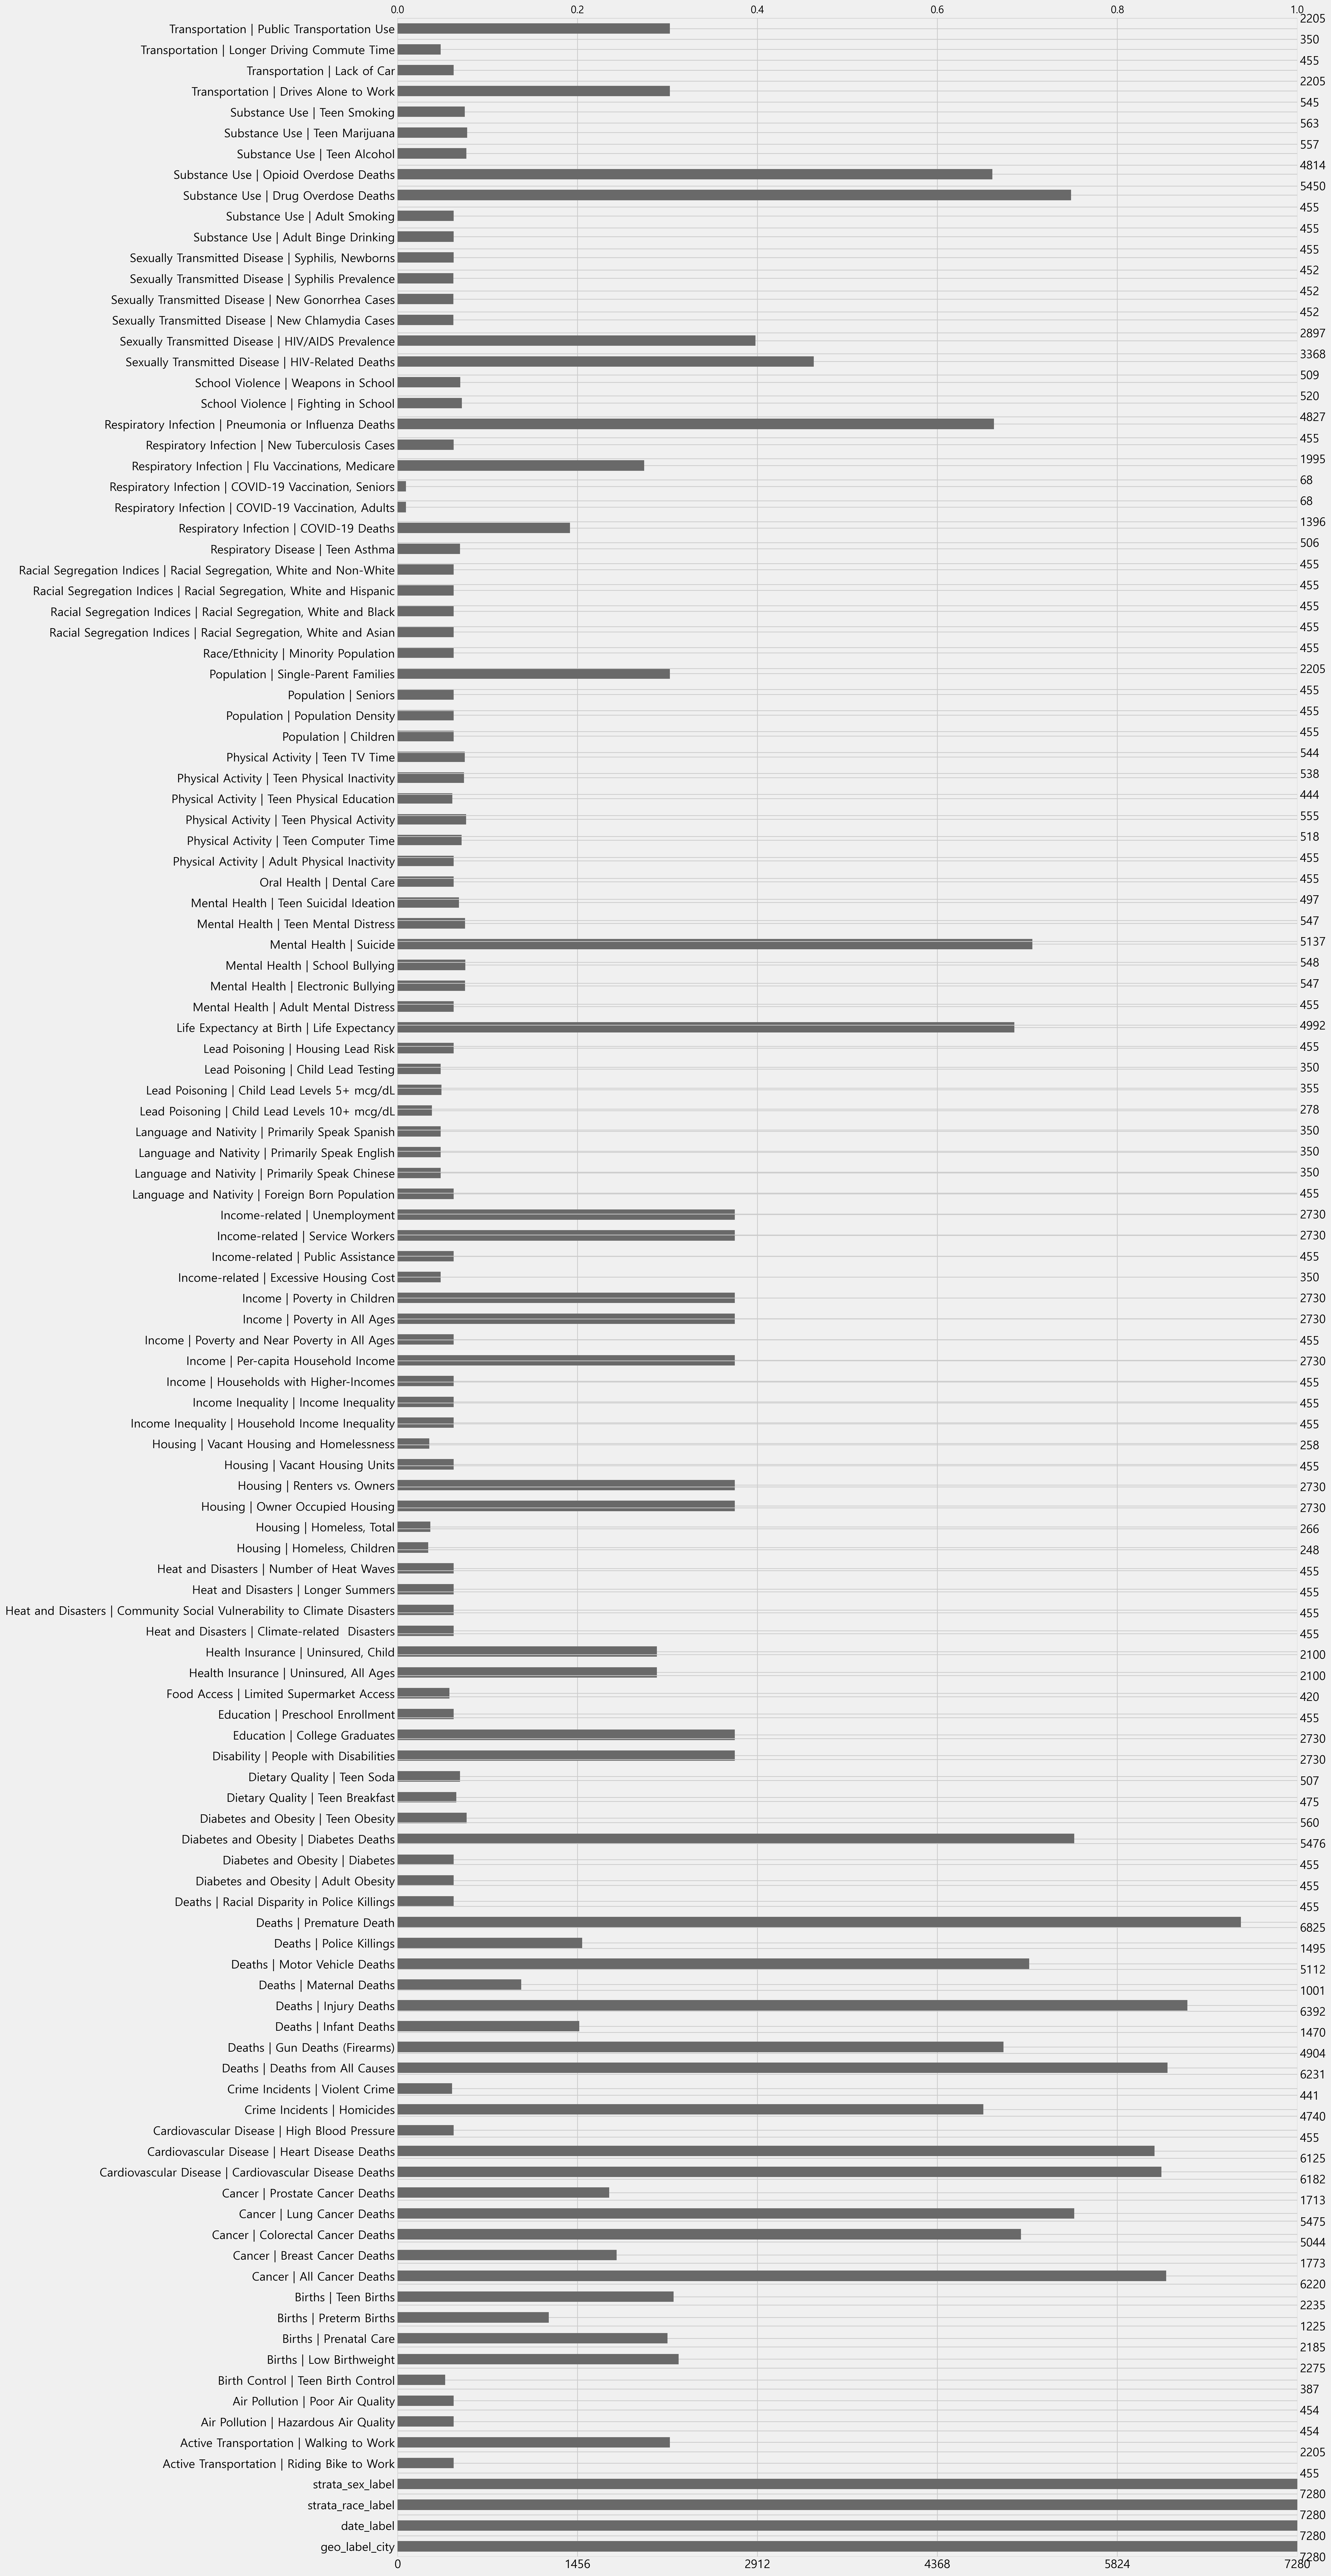

In [22]:
msno.bar(pvtb_entire)

In [ ]:
msno.heatmap(pvtb_entire, labels=False)

In [ ]:
pvtb_entire_T = pvtb_entire.T
depvar_cand = (pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.33].index)

In [ ]:
pvtb_entire_T

In [ ]:
indvar_cand = [col for col in pvtb_entire.columns.to_list() if col not in depvar_cand.to_list()]

In [ ]:
for idx, cand in enumerate(indvar_cand):
    print(idx, cand)

In [ ]:
depvar_cand = depvar_cand.to_list()

In [ ]:
depvar_cand = depvar_cand[4:]

In [ ]:
depvar_cand

In [ ]:
# Heuristic approach
cancer_cand = []
cardio_cand = [11,18,19,20,21,22]
diabetes_cand = [18,19,20,21,22,26]
expectancy_cand = []
suicide_cand = []
drug_cand = []
other_deaths_cand = [12,13,14,15,16,27,28,29,30,32]

### 독립변수 파악 방안
### 가장 단순한 방법 = Heuristic
### 실제 비슷한 연구에서 뭘 사용하는지?

``` ['Cancer | All Cancer Deaths',
 'Cancer | Colorectal Cancer Deaths',
 'Cancer | Lung Cancer Deaths',
 'Cardiovascular Disease | Cardiovascular Disease Deaths',
 'Cardiovascular Disease | Heart Disease Deaths',
 'Deaths | Deaths from All Causes',
 'Deaths | Gun Deaths (Firearms)',
 'Deaths | Injury Deaths',
 'Deaths | Motor Vehicle Deaths',
 'Deaths | Premature Death',
 'Diabetes and Obesity | Diabetes Deaths',
 'Life Expectancy at Birth | Life Expectancy',
 'Mental Health | Suicide',
 'Substance Use | Drug Overdose Deaths'] ```

# 통계적 확인
# 결측치? 이상치?가 많을 경우 사용하기 힘들어짐
# 분포 (특정 도시에만? 특정 년도에만? 특정 계층에만?)
# CI 값? - 



<AxesSubplot: >

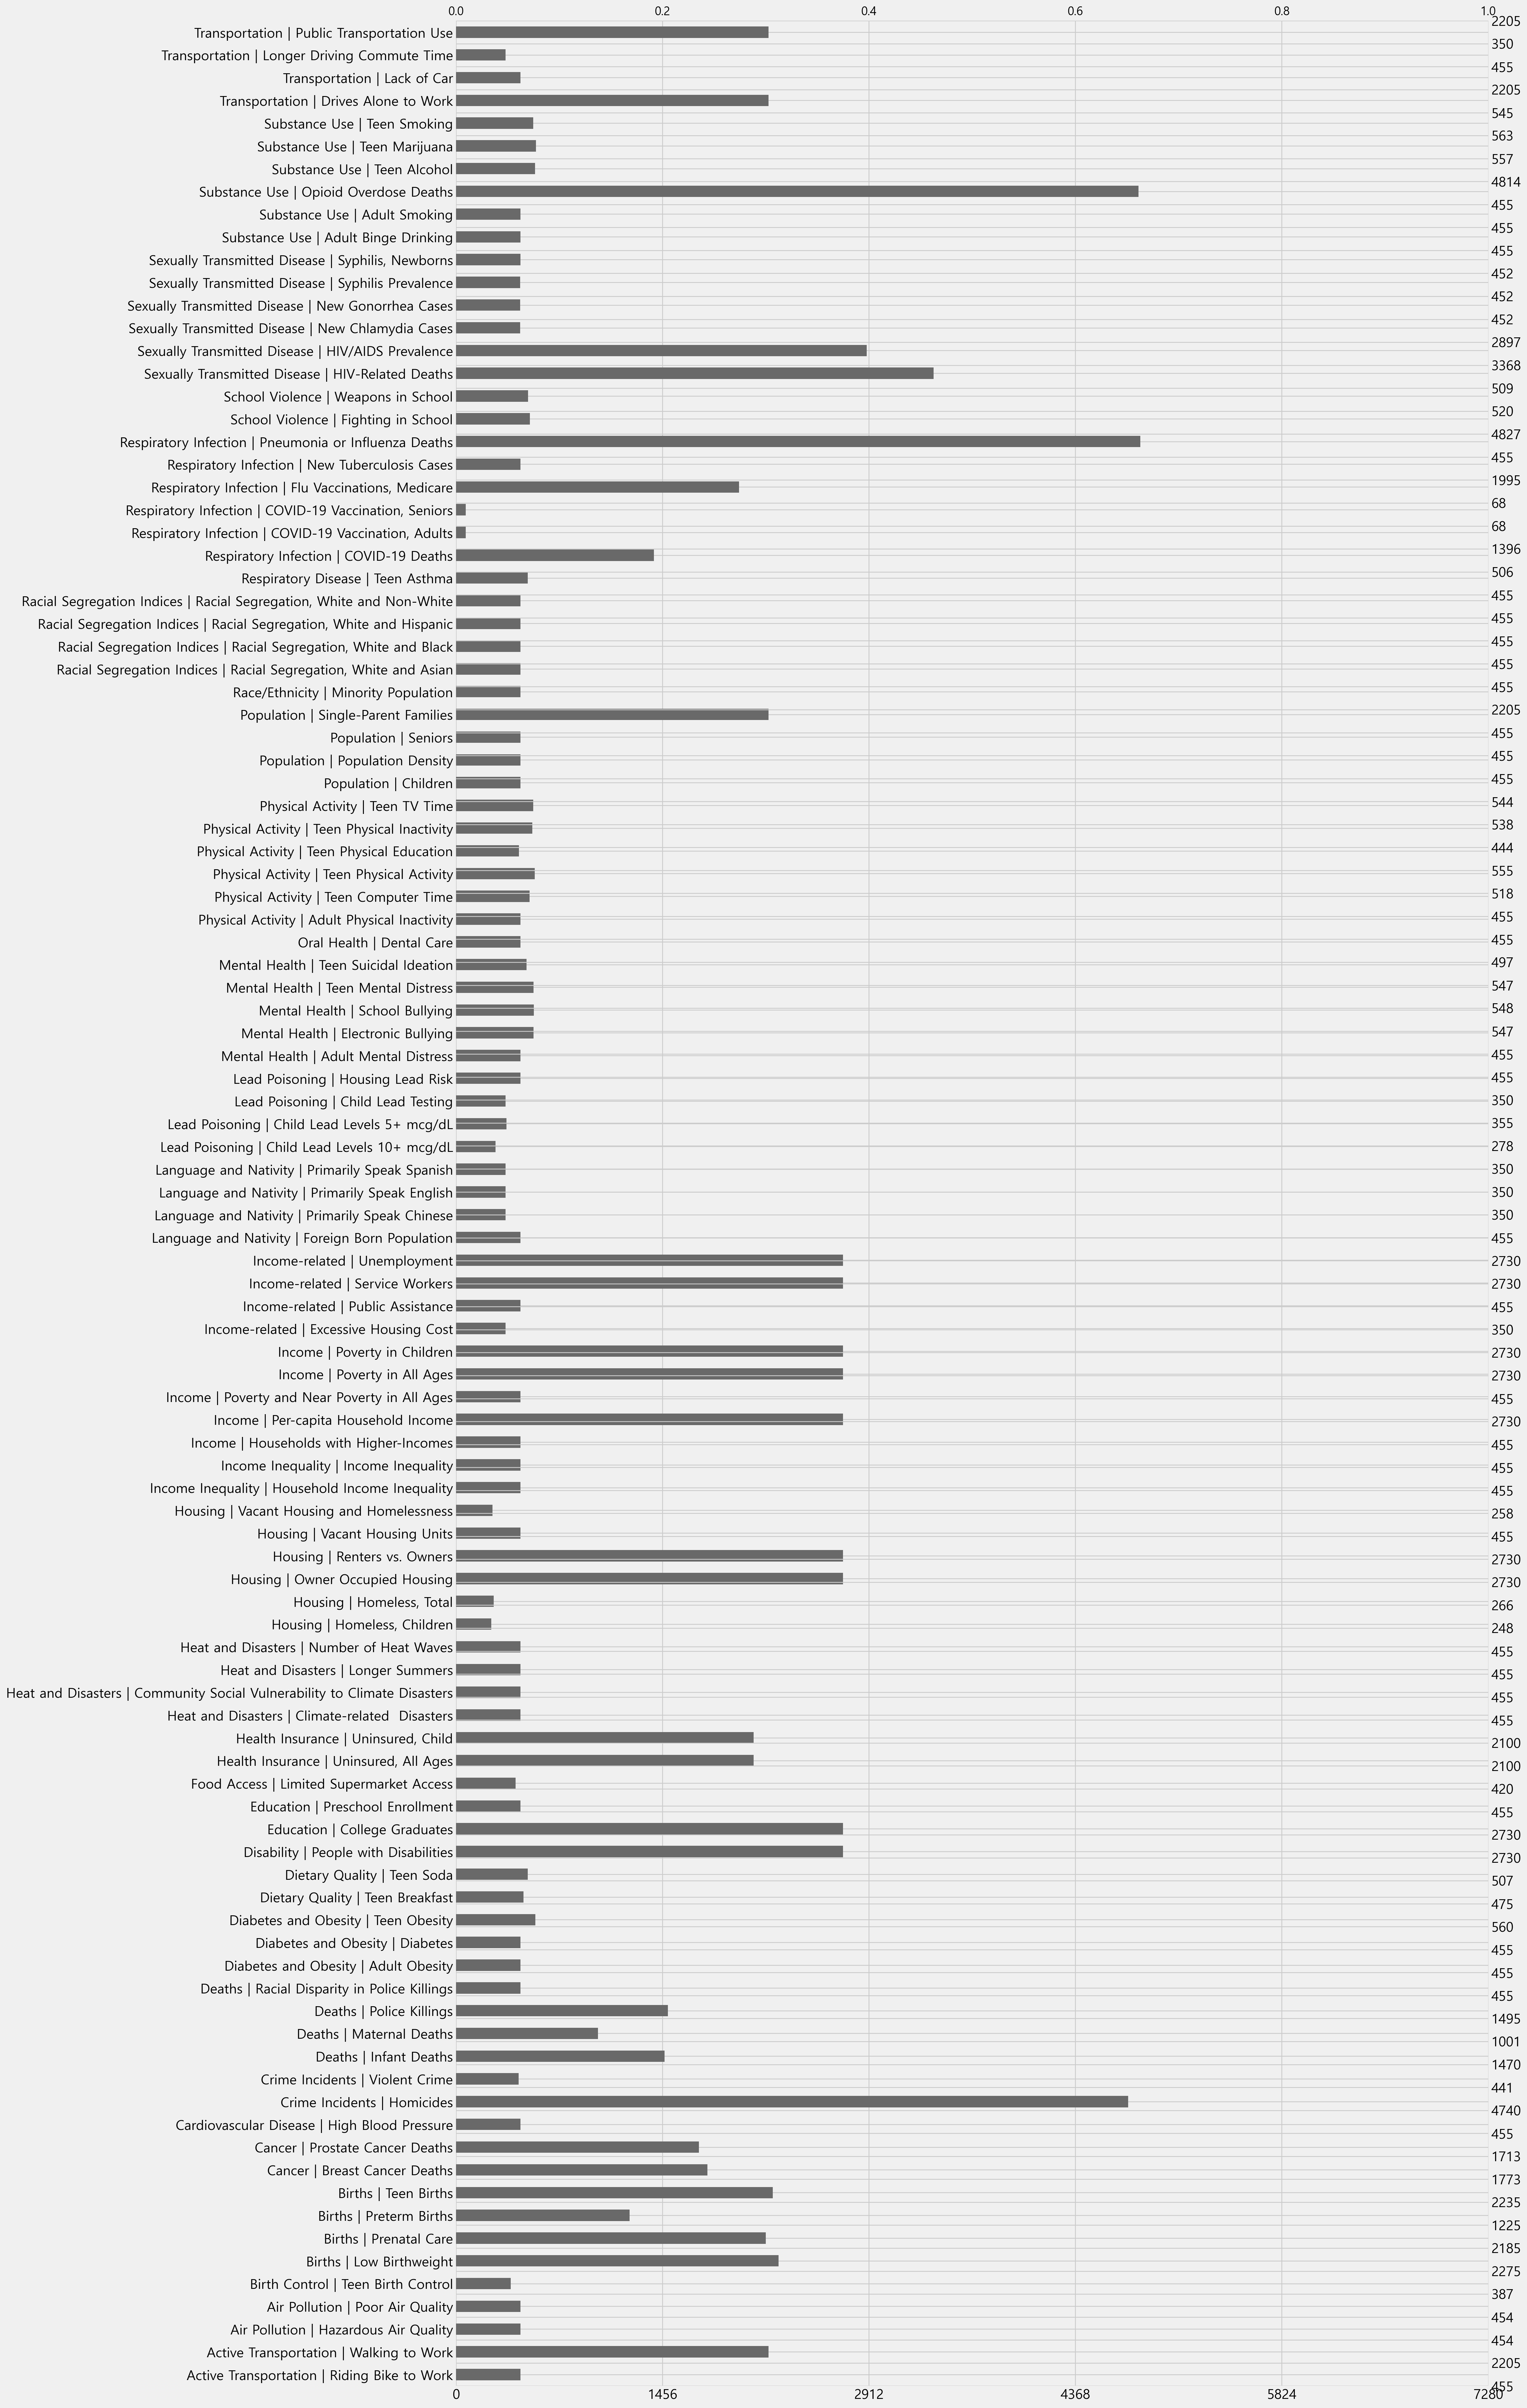

In [23]:
## 통계적 확인

msno.bar(pvtb_entire[indvar_cand])

### 기본형("All" / "Both") 에 대한 결측치 확인

<AxesSubplot: >

t:\miniconda3\envs\kdt\lib\site-packages\IPython\core\events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
t:\miniconda3\envs\kdt\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


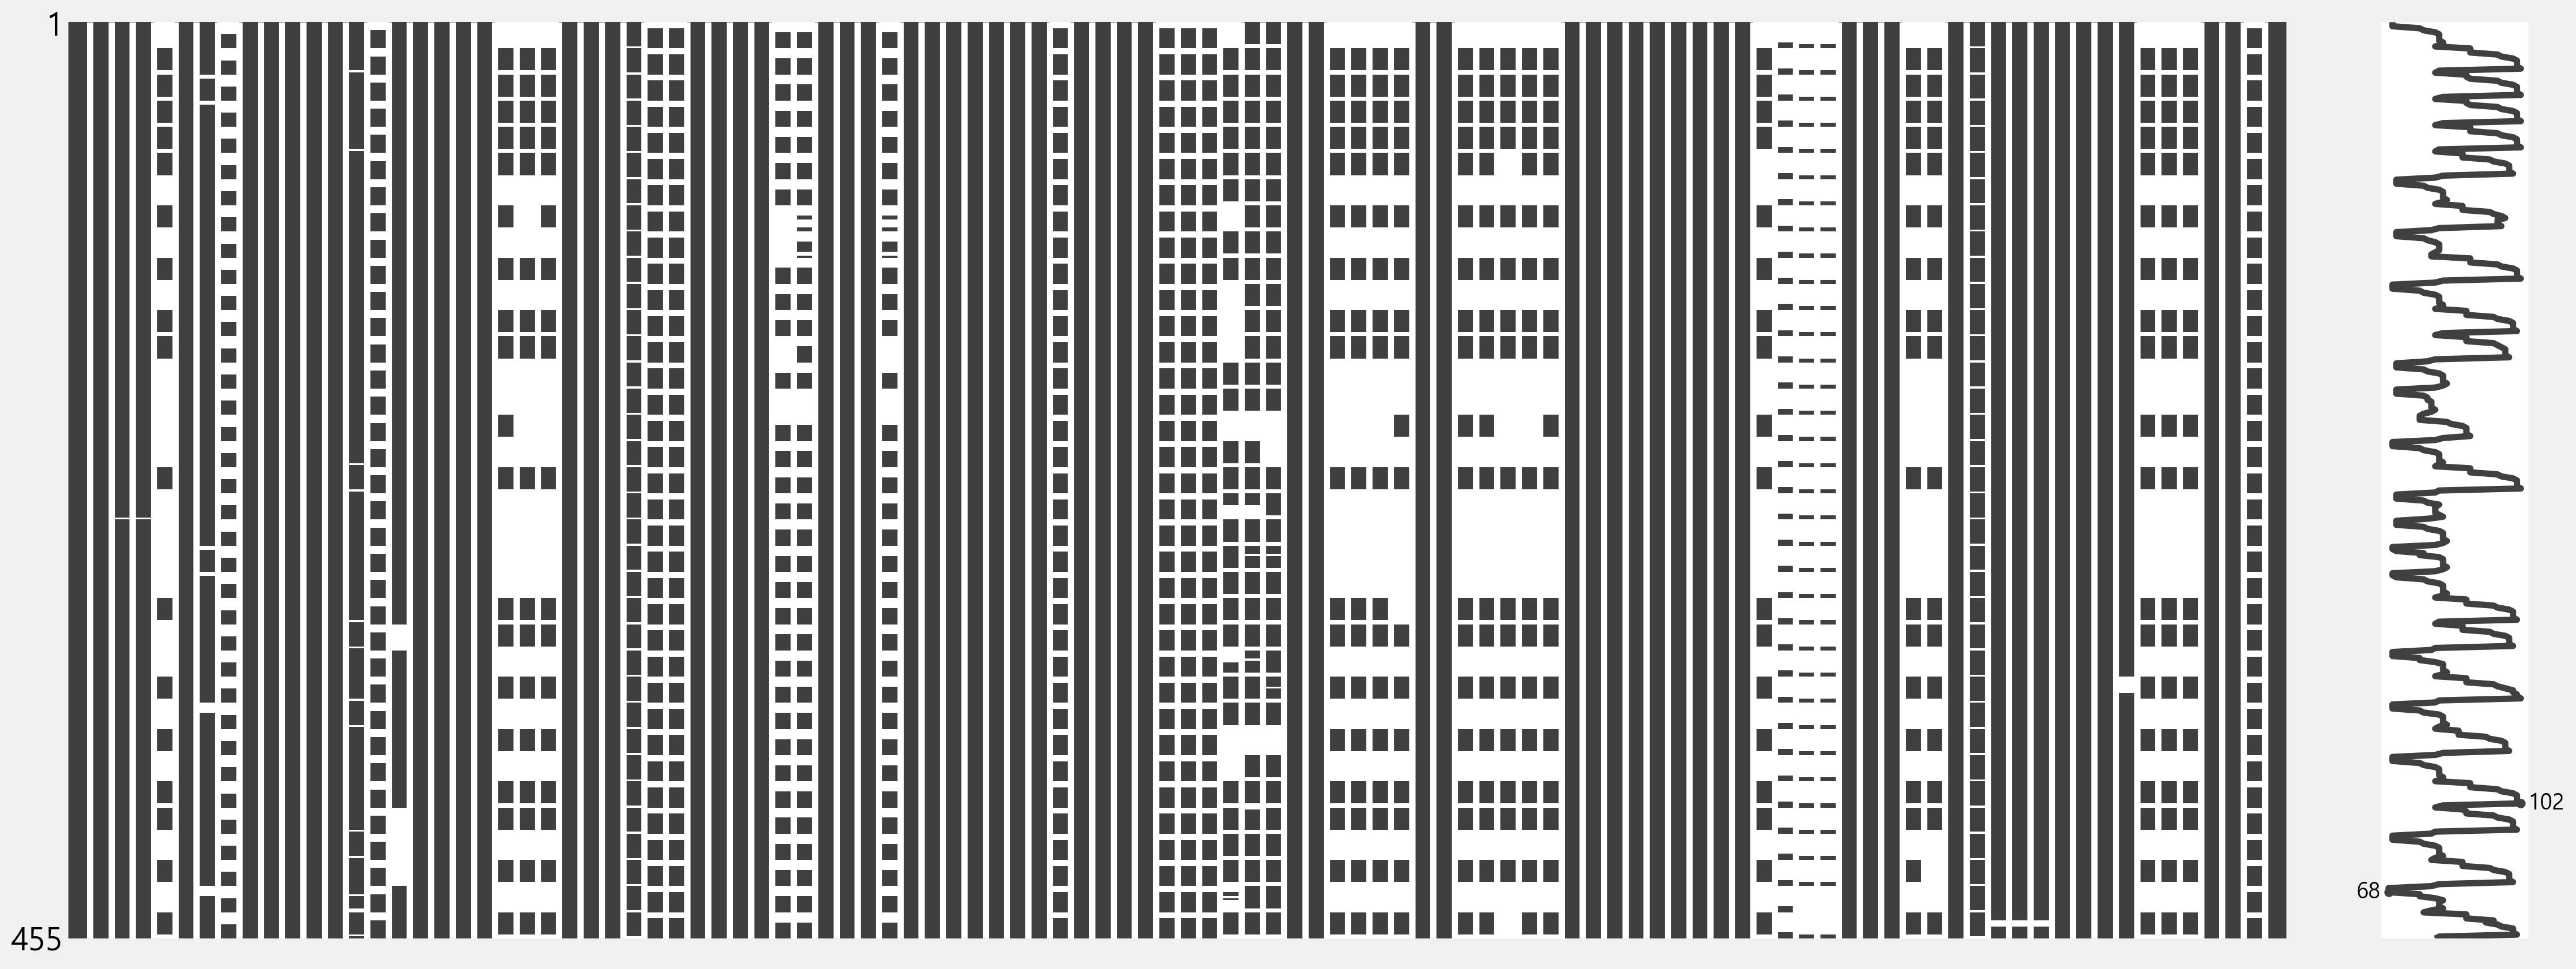

In [26]:
msno.matrix(pvtb_entire[(pvtb_entire["strata_race_label"] == "All") & (pvtb_entire["strata_sex_label"] == "Both")][indvar_cand])

<AxesSubplot: >

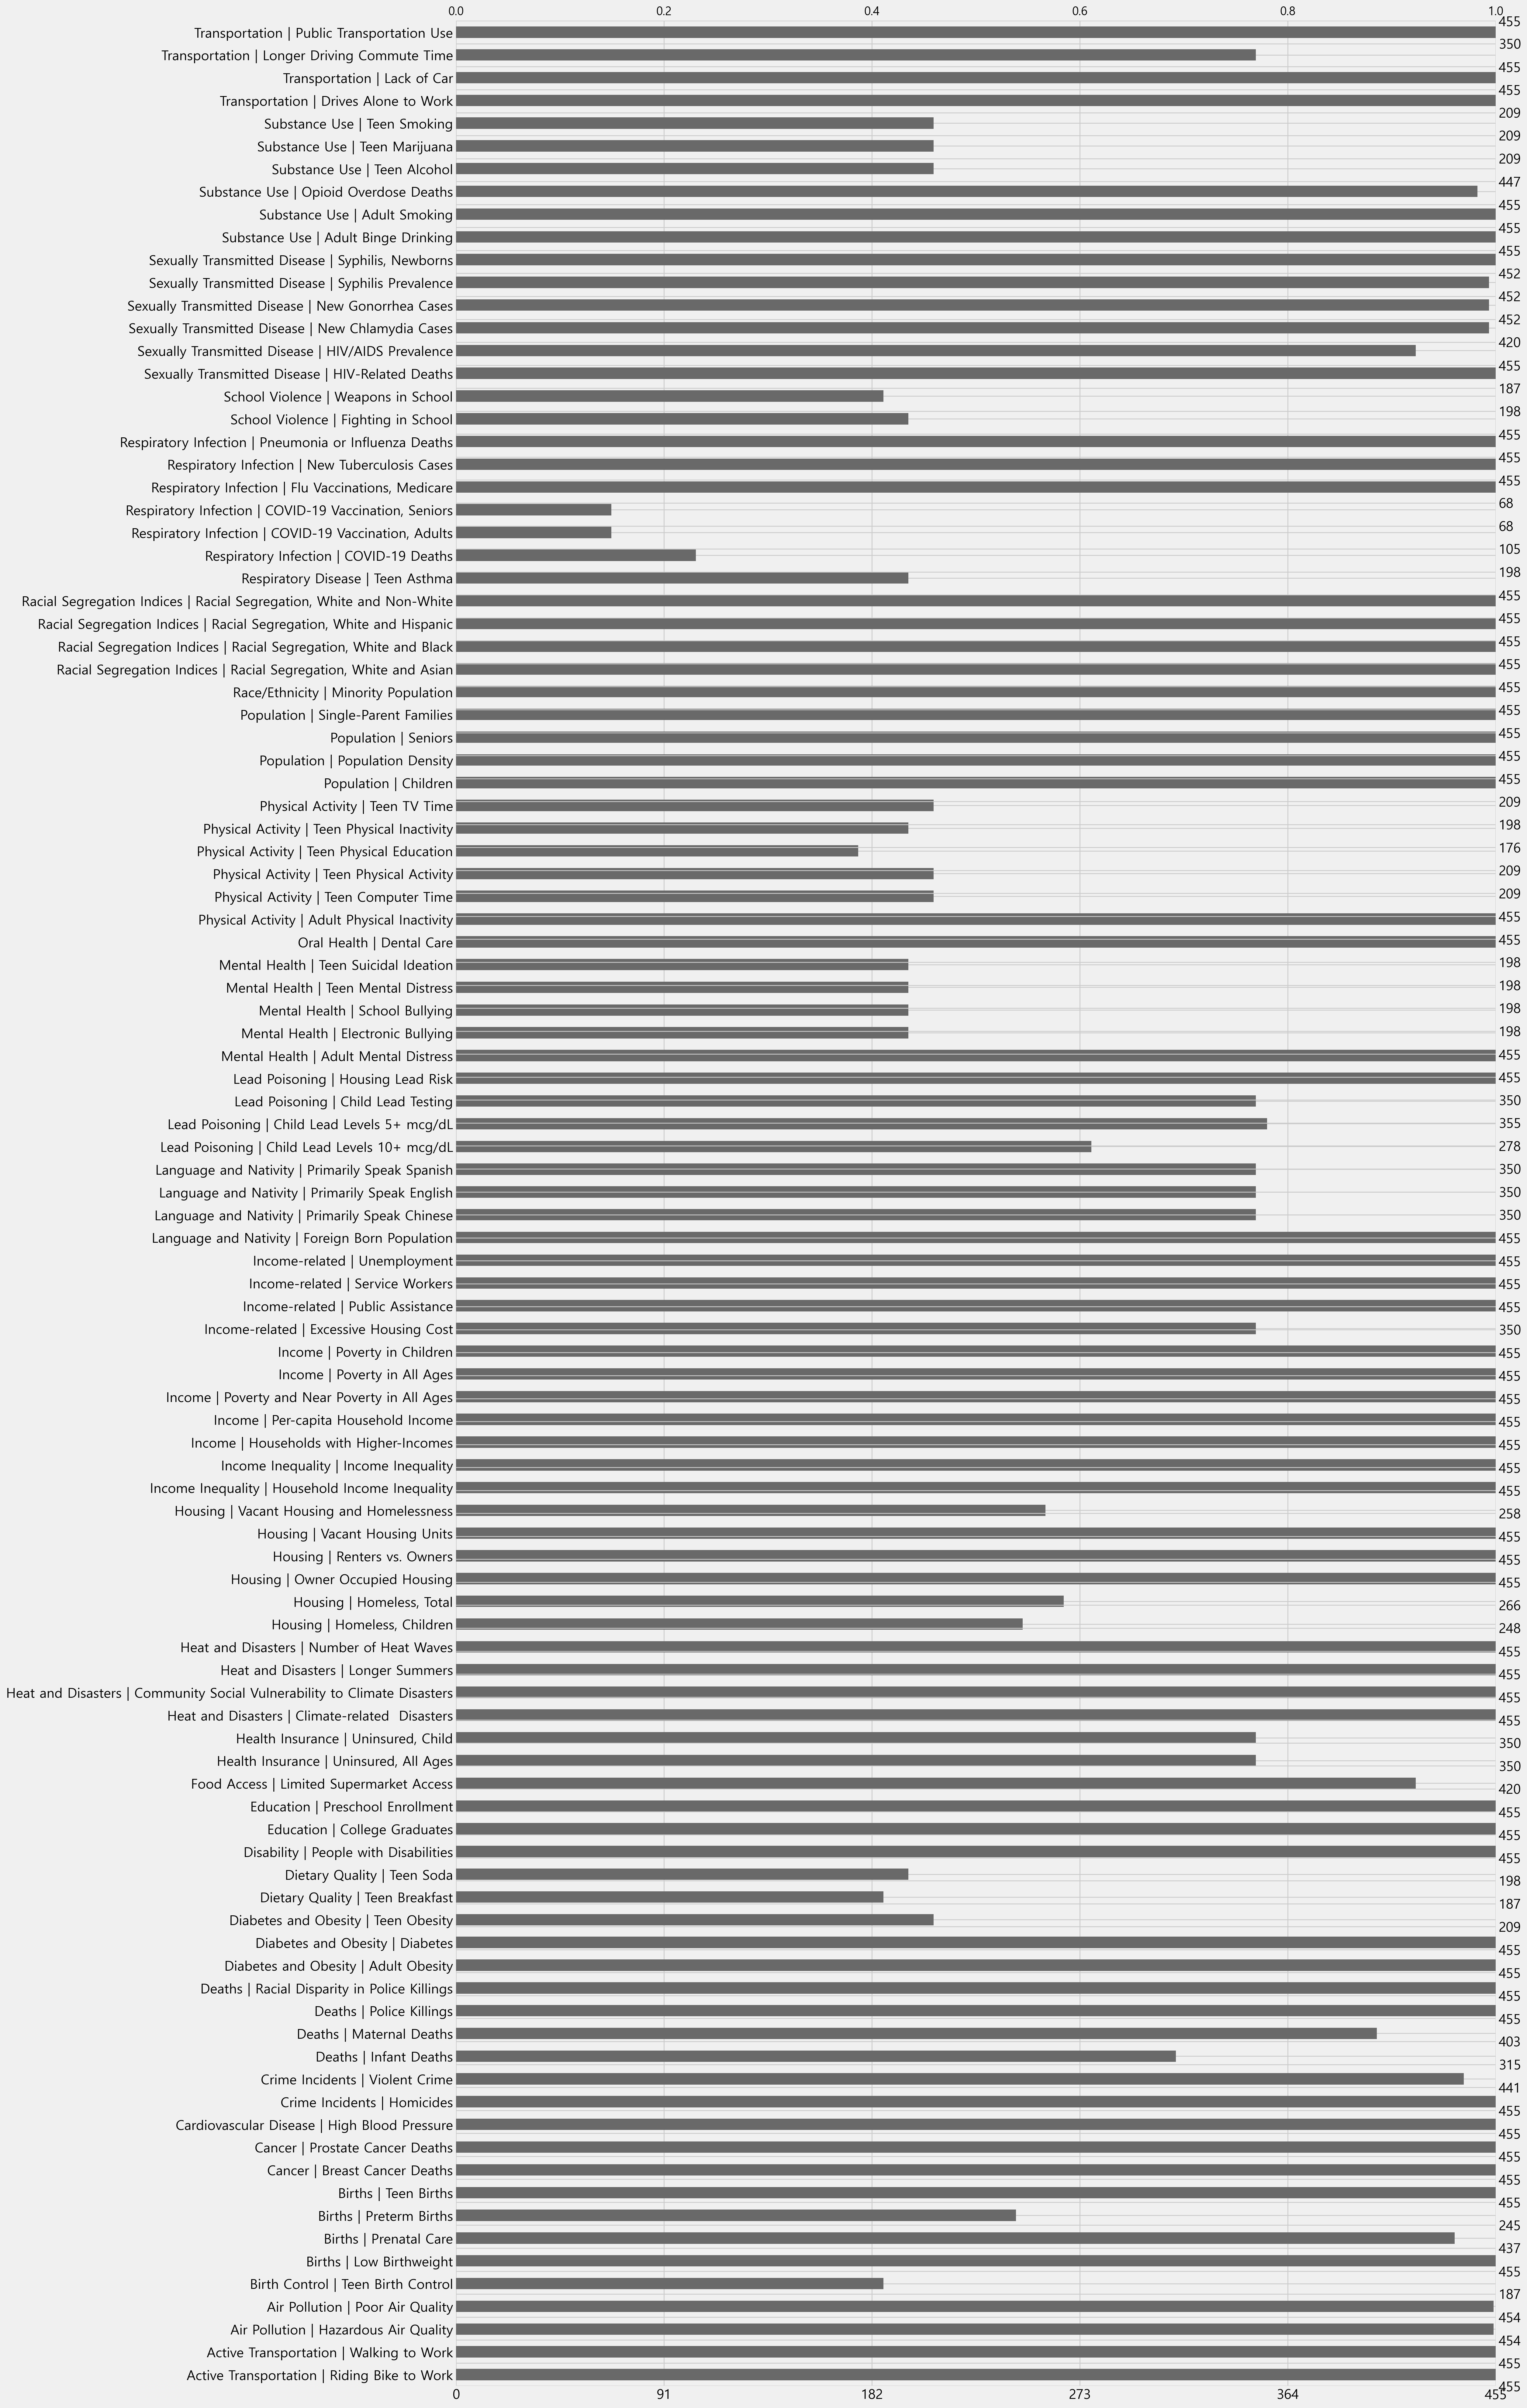

In [27]:
msno.bar(pvtb_entire[(pvtb_entire["strata_race_label"] == "All") & (pvtb_entire["strata_sex_label"] == "Both")][indvar_cand])

In [28]:
CI_somena_index = ["Physical Activity | Teen Computer Time",
"Physical Activity | Teen Physical Activity",
"Physical Activity | Teen TV Time",
"Respiratory Disease | Teen Asthma",
"Substance Use | Teen Alcohol",
"Substance Use | Teen Marijuana",
"Substance Use | Teen Smoking",
"Diabetes and Obesity | Teen Obesity"]

In [48]:
df_default = pvtb_entire[(pvtb_entire["strata_race_label"] == "All") & (pvtb_entire["strata_sex_label"] == "Both")][indvar_cand]

# null proportion
df_nullprop = pd.DataFrame({'majority_missing': (df_default.isna().sum() / len(df_default)) > 0.5})
df_nullprop = df_nullprop[df_nullprop].dropna()

df_nullprop

majority_missing
Birth Control | Teen Birth Control                             True
Diabetes and Obesity | Teen Obesity                            True
Dietary Quality | Teen Breakfast                               True
Dietary Quality | Teen Soda                                    True
Mental Health | Electronic Bullying                            True
Mental Health | School Bullying                                True
Mental Health | Teen Mental Distress                           True
Mental Health | Teen Suicidal Ideation                         True
Physical Activity | Teen Computer Time                         True
Physical Activity | Teen Physical Activity                     True
Physical Activity | Teen Physical Education                    True
Physical Activity | Teen Physical Inactivity                   True
Physical Activity | Teen TV Time                               True
Respiratory Disease | Teen Asthma                              True
Respiratory Infection | COVID-19 Deaths                        True
Respiratory Infection | COVID-19 Vaccination, A...             True
Respiratory Infection | COVID-19 Vaccination, S...             True
School Violence | Fighting in School                           True
School Violence | Weapons in School                            True
Substance Use | Teen Alcohol                                   True
Substance Use | Teen Marijuana                                 True
Substance Use | Teen Smoking                                   True

In [51]:
not_CI_somena_index = list(set(df_nullprop.index.to_list()) - set(CI_somena_index))

In [52]:
not_CI_somena_index

['Respiratory Infection | COVID-19 Vaccination, Seniors',
 'Mental Health | Teen Mental Distress',
 'Mental Health | Teen Suicidal Ideation',
 'Respiratory Infection | COVID-19 Deaths',
 'Mental Health | School Bullying',
 'Dietary Quality | Teen Breakfast',
 'School Violence | Weapons in School',
 'School Violence | Fighting in School',
 'Physical Activity | Teen Physical Education',
 'Physical Activity | Teen Physical Inactivity',
 'Mental Health | Electronic Bullying',
 'Dietary Quality | Teen Soda',
 'Respiratory Infection | COVID-19 Vaccination, Adults',
 'Birth Control | Teen Birth Control']

In [63]:
# df_teen = df_city[(df_city["metric_label"].isin(not_CI_somena_index)) & (df_city["strata_race_label"] == "All") & (df_city["strata_sex_label"] == "Both")]

pvtb_entire[(pvtb_entire["strata_race_label" ]== "All") & (pvtb_entire["strata_sex_label"] == "Both")][["geo_label_city"] + not_CI_somena_index].groupby("geo_label_city").count()

# fig, ax = plt.subplots(figsize=(20,20))
# table_teen.plot.bar(ax=ax)

Respiratory Infection | COVID-19 Vaccination, Seniors  \
geo_label_city                                                          
Austin                                                          2       
Baltimore                                                       2       
Boston                                                          2       
Charlotte                                                       2       
Chicago                                                         2       
Cleveland                                                       2       
Columbus                                                        2       
Dallas                                                          2       
Denver                                                          2       
Detroit                                                         2       
El Paso                                                         2       
Fort Worth                                                      2       
Houston                                                         2       
Indianapolis                                                    2       
Kansas City                                                     2       
Las Vegas                                                       2       
Long Beach                                                      2       
Los Angeles                                                     2       
Louisville                                                      2       
Memphis                                                         2       
Milwaukee                                                       2       
Minneapolis                                                     2       
New York City                                                   2       
Oakland                                                         2       
Oklahoma City                                                   2       
Philadelphia                                                    2       
Phoenix                                                         2       
Portland                                                        2       
San Antonio                                                     2       
San Diego                                                       2       
San Francisco                                                   2       
San Jose                                                        2       
Seattle                                                         2       
Tucson                                                          0       
Washington                                                      2       

                Mental Health | Teen Mental Distress  \
geo_label_city                                         
Austin                                             0   
Baltimore                                         11   
Boston                                            11   
Charlotte                                         11   
Chicago                                           11   
Cleveland                                         11   
Columbus                                           0   
Dallas                                            11   
Denver                                             0   
Detroit                                           11   
El Paso                                            0   
Fort Worth                                        11   
Houston                                           11   
Indianapolis                                       0   
Kansas City                                        0   
Las Vegas                                          0   
Long Beach                                         0   
Los Angeles                                       11   
Louisville                                         0   
Memphis                                            0   
Milwaukee                                          0   
Minneapolis               

In [64]:
pvtb_entire[(pvtb_entire["strata_race_label" ]== "All") & (pvtb_entire["strata_sex_label"] == "Both")][["date_label"] + not_CI_somena_index].groupby("date_label").count()

Respiratory Infection | COVID-19 Vaccination, Seniors  \
date_label                                                          
2010                                                        0       
2011                                                        0       
2012                                                        0       
2013                                                        0       
2014                                                        0       
2015                                                        0       
2016                                                        0       
2017                                                        0       
2018                                                        0       
2019                                                        0       
2020                                                        0       
2021                                                       34       
2022                                                       34       

            Mental Health | Teen Mental Distress  \
date_label                                         
2010                                          18   
2011                                          18   
2012                                          18   
2013                                          18   
2014                                          18   
2015                                          18   
2016                                          18   
2017                                          18   
2018                                          18   
2019                                          18   
2020                                          18   
2021                                           0   
2022                                           0   

            Mental Health | Teen Suicidal Ideation  \
date_label                                           
2010                                            18   
2011                                            18   
2012                                            18   
2013                                            18   
2014                                            18   
2015                                            18   
2016                                            18   
2017                                            18   
2018                                            18   
2019                                            18   
2020                                            18   
2021                                             0   
2022                                             0   

            Respiratory Infection | COVID-19 Deaths  \
date_label                                            
2010                                              0   
2011                                              0   
2012                                              0   
2013                                              0   
2014                                              0   
2015                                              0   
2016                                              0   
2017                                              0   
2018                                              0   
2019                                              0   
2020                                             35   
2021                                             35   
2022                                             35   

            Mental Health | School Bullying  Dietary Quality | Teen Breakfast  \
date_label                                                                      
2010                                     18                                17   
2011                                     18                                17   
2012                                     18                                17   
2013                                     18                                17   
2014                                     18                             